Author : Jeonghun Yoon

# Logistic regression (로지스틱 회귀)

**로지스틱 회귀**는 채무이행이 가능한지의 여부를 확률로 계산해야하는 신용정보 관련 산업이나 리스크 관련 산업에서 널리 사용되는 기법입니다. 로지스틱 회귀를 제대로 사용하기 위해서는 다음의 이론을 알아야 합니다.
 - Likelihood (우도)
 - Information Value (IV, 정보 가치)
 - Akaike Information Criteria (AIC)
 - Receiver Operating Characteristic (ROC 곡선)
 - Rank ordering (순위 정렬)
 - C-statistic / Concordance (C-통계량, 일치값)
 - K-S 통계량
 - 모집단 안정화 지수

## 1. 로지스틱 회귀 모델링

1. Feature selection
 1. 제외할 변수 및 변수의 적합성을 정의
 2. 초기 데이터를 준비하고 단일 변량 분석 실시
 3. 파생/더미 변수 생성
 4. 미세 분류와 개략 분류 (fine classing / coarse classing)
2. Model training
3. Model evaluation (validation check)

### Data set
- https://www.kaggle.com/crowdflower/twitter-user-gender-classification
- https://www.kaggle.com/shubhamjoshi2130of/abstract-data-set-for-credit-card-fraud-detection
- https://www.kaggle.com/c/home-credit-default-risk/data

데이터는 Kaggle의 Home Credit Default Risk의 데이터를 사용합니다. 고객 정보를 이용하여, 이 고객이 돈을 갚을 수 있는지 없는지를 예측하는 로지스틱 회귀 모형을 생성하겠습니다.

### 1. Pre feature selection

In [1]:
import pandas as pd
import numpy as np
import typing

pd.options.display.max_columns=None
pd.options.display.max_rows=None

In [2]:
COLUMNS = ['Status of existing checking account ', 
           'Duration in month',
           'Credit history', 
           'Purpose', 
           'Credit amount', 
           'Savings account/bonds', 
           'Present employment since', 
           'Installment rate in percentage of disposable income', 
           'Personal status and sex', 
           'Other debtors / guarantors', 
           'Present residence since', 
           'Property', 
           'Age in years', 
           'Other installment plans', 
           'Housing', 
           'Number of existing credits at this bank', 
           'Job', 
           'Number of people being liable to provide maintenance for', 
           'Telephone', 
           'foreign worker', 
           'target']

In [3]:
train_set = pd.read_csv('./german.csv', delimiter='\s+', names=COLUMNS, index_col=False)

In [4]:
train_set['target'] = train_set['target'] - 1

#### Information Value (IV), Weight of Evidence (WOE) 
모델에서 변수의 사용유무를 판단하는 feature selection에서 유용한 방법입니다. 주로 모델을 학습하기전 첫 단계에서 변수들을 제거하는 데 사용합니다. 최종 모델에서는 대략 10개 내외의 변수를 사용하도록 합니다. IV와 WOE 신용채무능력이 가능한(good) 고객과 불가능한(bad) 고객을 예측하는 로지스틱 회귀 모델링과 밀접한 관계가 있습니다. 신용 정보 관련분야에서는 good customer는 부채를 갚을 수 있는 고객, bad customer는 부채를 갚을 수 없는 고객을 뜻합니다. 일반적으로 이야기할 때는 good customer는 non-events를 의미하고 bad customer는 events를 의미합니다.

> 신용 관련 분야

$
\begin{align}
&\text{WOE} = ln{\frac{\text{distribution of good}}{\text{distribution of bad}}} \\
&\text{IV} = \sum{(\text{WOE} \times (\text{distribution of good} - \text{distribution of bad}))}\\
\end{align}
$

>일반적

$
\begin{align}
&\text{WOE} = ln{\frac{\text{distribution of non-events}}{\text{distribution of events}}} \\
&\text{IV} = \sum{(\text{WOE} \times (\text{distribution of non-events} - \text{distribution of events}))}\\
\end{align}
$

<U>구현시 생각해봐야 할 점</U>
- line 6, 구간을 나눌 때(bin) 중복되는 데이터에 대해서 나누지 못하는 경우가 생긴다. 구현시에는 중복 데이터를 무시하여, 데이터에 맞추어 구간이 나누어지도록 했다. 만약 `rank`, `method='first'`를 사용하면 중복되는 데이터들의 ranking을 사용하므로 중복을 방지하여 구간이 나누어지도록 한다. 하지만 같은 데이터임에도 불구하고 다른 구간에 속할 위험이 있다. 따라서 여기서는 ranking을 사용하지 않았다.
- *inf* 값이 존재하는 구간은 제외하고 IV를 구하도록 하였다. 이 부분도 고민해 볼 부분이다.

In [6]:
def calc_iv(df, col, target):
    if df[col].dtype == 'object':
        col_df = df.groupby(col)[target].agg(['count', 'sum'])
    else:
        col_bin = col +'_bin'
        df.loc[:, col_bin] = pd.qcut(df[col], 10, duplicates='drop')  # pd.qcut(df[col].rank(method='first'), 10)
        col_df = df.groupby(col_bin)[target].agg(['count', 'sum'])
    col_total = col + '_total'
    col_good = col + '_good'
    col_bad = col + '_bad'
    col_good_dist = col + '_good_dist'
    col_bad_dist = col + '_bad_dist'
    col_woe = col + '_woe'
    col_iv = col + '_iv'
    
    col_df.columns = [col_total, col_bad]
    col_df[col_good] = col_df[col_total] - col_df[col_bad]
    col_df[col_good_dist] = col_df[col_good] / sum(col_df[col_good])
    col_df[col_bad_dist] = col_df[col_bad] / sum(col_df[col_bad])
    col_df[col_woe] = np.log(col_df[col_good_dist] / col_df[col_bad_dist])
    col_df[col_iv] = col_df[col_woe] * (col_df[col_good_dist] - col_df[col_bad_dist])
    # Inf 값이 있는경우는, 그 값을 제외하고 계산해본다. 과연 맞는지 확인해 볼 필요가 있다.
    iv_val = sum(filter(lambda x: x != float('inf'), col_df[col_iv]))
    return (col, iv_val, df[col].dtype, sum(df[col].notnull()))

In [7]:
train_set.reset_index(inplace=True)

In [8]:
import operator
copied_train_set = train_set.copy()
iv_list = []
for col in copied_train_set.columns.tolist():
    if col != 'target':
        iv_list.append(calc_iv(copied_train_set, col, 'target'))
    
iv_list = sorted(iv_list, key=operator.itemgetter(1), reverse=True)

<U>IV 값에 따른 예측력</U>

|<center>IV</center>|<center>예측력</center>|
|:-----------:|:------------------------------:|
|<center>0 to 0.02</center>|<center>무의미</center>|
|<center>0.02 to 0.1</center>|<center>낮은 예측</center>|
|<center>0.1 to 0.3</center>|<center>중간 예측</center>|
|<center>0.3 to 0.5</center>|<center>강한 예측</center>|
|<center>0.5 to 1</center>|<center>너무 강한 예측(의심되는 수치)</center>|

In [9]:
iv_list

[('Status of existing checking account ',
  0.6660115033513336,
  dtype('O'),
  1000),
 ('Credit history', 0.2932335473908263, dtype('O'), 1000),
 ('Duration in month', 0.24654188863116078, dtype('int64'), 1000),
 ('Savings account/bonds', 0.19600955690422672, dtype('O'), 1000),
 ('Purpose', 0.16919506567307832, dtype('O'), 1000),
 ('Credit amount', 0.11363743954612221, dtype('int64'), 1000),
 ('Property', 0.11263826240979674, dtype('O'), 1000),
 ('Age in years', 0.10062227273111429, dtype('int64'), 1000),
 ('Present employment since', 0.086433631026641, dtype('O'), 1000),
 ('Housing', 0.08329343361549926, dtype('O'), 1000),
 ('Other installment plans', 0.057614541955647885, dtype('O'), 1000),
 ('index', 0.04808676382741298, dtype('int64'), 1000),
 ('Personal status and sex', 0.04467067763379073, dtype('O'), 1000),
 ('foreign worker', 0.04387741201028899, dtype('O'), 1000),
 ('Other debtors / guarantors', 0.032019322019485055, dtype('O'), 1000),
 ('Installment rate in percentage of dis

In [10]:
# 예측력을 가지는 데이터는 모두 사용하도록 하자.
col_cand = list(filter(lambda x: (x[1] > 0.02) & (x[3] == len(train_set)), iv_list))

In [11]:
col_cand

[('Status of existing checking account ',
  0.6660115033513336,
  dtype('O'),
  1000),
 ('Credit history', 0.2932335473908263, dtype('O'), 1000),
 ('Duration in month', 0.24654188863116078, dtype('int64'), 1000),
 ('Savings account/bonds', 0.19600955690422672, dtype('O'), 1000),
 ('Purpose', 0.16919506567307832, dtype('O'), 1000),
 ('Credit amount', 0.11363743954612221, dtype('int64'), 1000),
 ('Property', 0.11263826240979674, dtype('O'), 1000),
 ('Age in years', 0.10062227273111429, dtype('int64'), 1000),
 ('Present employment since', 0.086433631026641, dtype('O'), 1000),
 ('Housing', 0.08329343361549926, dtype('O'), 1000),
 ('Other installment plans', 0.057614541955647885, dtype('O'), 1000),
 ('index', 0.04808676382741298, dtype('int64'), 1000),
 ('Personal status and sex', 0.04467067763379073, dtype('O'), 1000),
 ('foreign worker', 0.04387741201028899, dtype('O'), 1000),
 ('Other debtors / guarantors', 0.032019322019485055, dtype('O'), 1000),
 ('Installment rate in percentage of dis

### 2. Feature selection with train

#### Backword variable selection
 - 전체 feature를 대상으로 모델에 대한 fit을 구하고, 가장 상관이 없는 feature부터 삭제해가는 기법입니다.
 
#### Forward selection
 - 각각의 feature에 대해, 모델에 대한 fit이 가장 높은 feature부터 추가해가는 기법입니다.

In [12]:
# Categorycal column에 대하여 one hot vector를 구합니다.
def get_one_hot_df(ser, name, del_list):
    one_hot_df = pd.get_dummies(ser, prefix=name)
    del_list.append(one_hot_df.columns[-1])
    return one_hot_df.iloc[:, :-1]

In [13]:
features = pd.DataFrame()
numeric_col_names = []
del_lists = []

for col in col_cand:
    if col[2] == 'object':
        col_df = get_one_hot_df(train_set[col[0]], col[0], del_lists)
        features = pd.concat([features, col_df], axis=1)
    else:
        features[col[0]] = train_set[col[0]]
        numeric_col_names.append(col[-1])

In [14]:
print(numeric_col_names)
print(del_lists)

[1000, 1000, 1000, 1000, 1000]
['Status of existing checking account _A14', 'Credit history_A34', 'Savings account/bonds_A65', 'Purpose_A49', 'Property_A124', 'Present employment since_A75', 'Housing_A153', 'Other installment plans_A143', 'Personal status and sex_A94', 'foreign worker_A202', 'Other debtors / guarantors_A103']


NaN 값은 어떻게 처리하면 좋을까?
 - Categorycal의 경우 : NA도 하나의 카테고리처럼 다룬다.
 - Numeric의 경우 : 0, min 값

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Feature normalization (https://sebastianraschka.com/Articles/2014_about_feature_scaling.html)
 - k-nearest neighbors with an Euclidean distance measure if want all features to contribute equally
 - k-means (see k-nearest neighbors)
 - logistic regression, SVMs, perceptrons, neural networks etc. if you are using gradient descent/ascent-based optimization, otherwise some weights will update much faster than others
 - linear discriminant analysis, principal component analysis, kernel principal component analysis since you want to find directions of maximizing the variance (under the constraints that those directions/eigenvectors/principal components are orthogonal); you want to have features on the same scale since you’d emphasize variables on “larger measurement scales” more. There are many more cases than I can possibly list here … I always recommend you to think about the algorithm and what it’s doing, and then it typically becomes obvious whether we want to scale your features or not.

Scale 조정을 할 때, train set 과 test set 을 동시에 하였다. scale 조정법에는 어떤 것들이 있을까?
- Min-max scale
- Standardization

In [16]:
train_x, test_x, train_y, test_y = train_test_split(
    features, train_set['target'].values, test_size=0.3, random_state=42)

In [17]:
import statsmodels.api as sm

In [134]:
logistic_model = sm.Logit(
    train_y, 
    sm.add_constant(train_x)
).fit()

Optimization terminated successfully.
         Current function value: 0.456197
         Iterations 7


In [135]:
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:                          Logit   Df Residuals:                      657
Method:                           MLE   Df Model:                           42
Date:                Sun, 28 Oct 2018   Pseudo R-squ.:                  0.2517
Time:                        21:14:09   Log-Likelihood:                -319.34
converged:                       True   LL-Null:                       -426.75
                                        LLR p-value:                 4.714e-25
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -4.9314      1.375     -3.586      0.000      -7.627      -2.236
Status of existing checking account _A11                1.5366      0.275      5.583      0.000       0.997       2.076
Status of existing checking account _A12                1.2079      0.269      4.484      0.000       0.680       1.736
Status of existing checking account _A13                0.5017      0.466      1.076      0.282      -0.412       1.416
Credit history_A30                                      1.4087      0.484      2.909      0.004       0.460       2.358
Credit history_A31                                      1.2994      0.489      2.657      0.008       0.341       2.258
Credit history_A32                                      0.7921      0.262      3.027      0.002       0.279       1.305
Credit history_A33                                      0.3271      0.399      0.819      0.413      -0.456       1.110
Duration in month                                       0.0194      0.011      1.793      0.073      -0.002       0.041
Savings account/bonds_A61                               0.6859      0.298      2.300      0.021       0.101       1.270
Savings account/bonds_A62                               0.3945      0.402      0.980      0.327      -0.394       1.183
Savings account/bonds_A63                              -0.0576      0.529     -0.109      0.913      -1.094       0.979
Savings account/bonds_A64                              -0.3701      0.646     -0.573      0.567      -1.636       0.896
Purpose_A40                                             0.5771      0.394      1.466      0.143      -0.194       1.349
Purpose_A41                                            -1.0714      0.512     -2.094      0.036      -2.074      -0.068
Purpose_A410                                           -0.4272      0.846     -0.505      0.613      -2.085       1.230
Purpose_A42                                            -0.5256      0.418     -1.258      0.208      -1.345       0.293
Purpose_A43                                            -0.4600      0.398     -1.155      0.248      -1.241       0.321
Purpose_A44                                            -0.0392      0.831     -0.047      0.962      -1.667       1.589
Purpose_A45                                            -0.0333      0.694     -0.048      0.962      -1.394       1.327
Purpose_A46                                             0.6796      0.580      1.173      0.241      -0.456       1.815
Purpose_A48                                            -1.5269      1.260     -1.212      0.226      -3.996       0.942
Credit amount                                           0.0001   4.78e-05      2.339      0.019    1.82e-05       0.000
Property_A121                                          -0.7163      0.508     -1.409      0.159      -1.712       0.280
P

가장 무의미한 변수는, Purpose_A44, Purpose_A45 이다.

#### Variance Inflation Factor (VIF)

다중공선성(multicolinearity)이란 예측변수들간의 ($X's$) 상관성이 높은지를 파악하는 것이며 이것을 VIF로 판단하게 됩니다. VIF는 예측변수들이 상관성이 있을때 추정 회귀 계수의 산포 크기를 측정하는 것이며 산포거 커질수록 모형은 신뢰할 수 없게 됩니다. VIF 값이 1 근방에 있으면 다중공선성이 없어서 모델을 신뢰할 수 있게 되고, 만약 10 이상이면 매우 높은 다중 공선성이 있는 것으로 판단합니다.

$VIF(x_1)=\frac{1}{1-R^2(x_1)}$

$R^2$의 값이 작아야합니다.

In [27]:
vif_cand_cols = train_x.columns.values

In [34]:
vif_tuple_list = []
for i in range(0, len(vif_cand_cols)):
    xvars = list(vif_cand_cols)
    yvar = xvars.pop(i)
    mod = sm.OLS(train_x[yvar], sm.add_constant(train_x[xvars]))
    res = mod.fit()
    vif = 1 / (1 - res.rsquared)
    vif_tuple_list.append((yvar, round(vif, 3)))
print(sorted(vif_tuple_list, key=operator.itemgetter(1), reverse=True))

[('Housing_A152', 6.386), ('Property_A123', 5.503), ('Property_A121', 5.429), ('Housing_A151', 5.124), ('Property_A122', 4.781), ('Personal status and sex_A93', 3.714), ('Purpose_A43', 3.467), ('Personal status and sex_A92', 3.34), ('Purpose_A40', 3.235), ('Purpose_A42', 2.683), ('Credit amount', 2.464), ('Purpose_A41', 2.235), ('Duration in month', 2.018), ('Other debtors / guarantors_A101', 1.996), ('Savings account/bonds_A61', 1.905), ('Other debtors / guarantors_A102', 1.879), ('Present employment since_A73', 1.874), ('Present employment since_A72', 1.8), ('Present employment since_A74', 1.64), ('Purpose_A46', 1.591), ('Personal status and sex_A91', 1.561), ('Credit history_A32', 1.502), ('Savings account/bonds_A62', 1.5), ('Status of existing checking account _A11', 1.498), ('Status of existing checking account _A12', 1.433), ('Age in years', 1.427), ('Installment rate in percentage of disposable income', 1.338), ('Credit history_A33', 1.332), ('Savings account/bonds_A63', 1.325),

#### C-statistic 계산

In [51]:
pred_n_class = pd.DataFrame({'probs': logistic_model.predict(sm.add_constant(train_x)), 'class': train_y})

In [89]:
zeros = pred_n_class[pred_n_class['class']==0]
ones = pred_n_class[pred_n_class['class']==1]

In [90]:
def cross_join(df1, df2, **kwargs):
    df1.loc[:, '_tmpkey'] = 1
    df2.loc[:, '_tmpkey'] = 1
    res = pd.merge(df1, df2, on='_tmpkey', **kwargs).drop('_tmpkey', axis=1)
    res.index = pd.MultiIndex.from_product((df1.index, df2.index))
    df1.drop('_tmpkey', axis=1, inplace=True)
    df2.drop('_tmpkey', axis=1, inplace=True)
    
    return res

In [92]:
joined_data = cross_join(ones, zeros)

/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

In [94]:
joined_data['concordant_pair'] = 0
joined_data.loc[joined_data['probs_x'] > joined_data['probs_y'], 'concordant_pair'] = 1
joined_data['discordant_pair'] = 0
joined_data.loc[joined_data['probs_x'] < joined_data['probs_y'], 'discordant_pair'] = 1
joined_data['tied_pair'] = 0
joined_data.loc[joined_data['probs_x'] == joined_data['probs_y'], 'tied_pair'] = 1

p_conc = sum(joined_data['concordant_pair']) / float(len(joined_data))
p_disc = sum(joined_data['discordant_pair']) / float(len(joined_data))

c_statistic = 0.5 + (p_conc - p_disc) / 2.0

In [95]:
print(c_statistic)

0.826143306795038


In [96]:
del_cols_insig = []

In [104]:
del_cols_insig.append('Purpose_A44')
del_cols_insig.append('Purpose_A45')

==========
1. 의미없는 변수 삭제

In [105]:
logistic_model = sm.Logit(
    train_y, 
    sm.add_constant(train_x.drop(del_cols_insig, axis=1))
).fit()

Optimization terminated successfully.
         Current function value: 0.456200
         Iterations 7


In [106]:
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:                          Logit   Df Residuals:                      659
Method:                           MLE   Df Model:                           40
Date:                Sun, 28 Oct 2018   Pseudo R-squ.:                  0.2517
Time:                        20:34:04   Log-Likelihood:                -319.34
converged:                       True   LL-Null:                       -426.75
                                        LLR p-value:                 8.692e-26
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -4.9425      1.363     -3.626      0.000      -7.614      -2.271
Status of existing checking account _A11                1.5357      0.274      5.610      0.000       0.999       2.072
Status of existing checking account _A12                1.2079      0.269      4.484      0.000       0.680       1.736
Status of existing checking account _A13                0.5013      0.466      1.076      0.282      -0.412       1.414
Credit history_A30                                      1.4103      0.482      2.924      0.003       0.465       2.356
Credit history_A31                                      1.2993      0.489      2.657      0.008       0.341       2.258
Credit history_A32                                      0.7912      0.261      3.029      0.002       0.279       1.303
Credit history_A33                                      0.3285      0.399      0.824      0.410      -0.453       1.110
Duration in month                                       0.0195      0.011      1.804      0.071      -0.002       0.041
Savings account/bonds_A61                               0.6861      0.297      2.308      0.021       0.103       1.269
Savings account/bonds_A62                               0.3948      0.402      0.982      0.326      -0.393       1.183
Savings account/bonds_A63                              -0.0576      0.529     -0.109      0.913      -1.094       0.979
Savings account/bonds_A64                              -0.3687      0.645     -0.572      0.568      -1.633       0.896
Purpose_A40                                             0.5893      0.340      1.736      0.083      -0.076       1.255
Purpose_A41                                            -1.0600      0.476     -2.226      0.026      -1.993      -0.127
Purpose_A410                                           -0.4168      0.828     -0.503      0.615      -2.040       1.207
Purpose_A42                                            -0.5140      0.372     -1.382      0.167      -1.243       0.215
Purpose_A43                                            -0.4478      0.346     -1.295      0.195      -1.125       0.230
Purpose_A46                                             0.6916      0.545      1.268      0.205      -0.377       1.761
Purpose_A48                                            -1.5146      1.244     -1.218      0.223      -3.952       0.923
Credit amount                                           0.0001   4.78e-05      2.340      0.019    1.82e-05       0.000
Property_A121                                          -0.7150      0.508     -1.408      0.159      -1.710       0.280
Property_A122                                          -0.3146      0.505     -0.623      0.534      -1.305       0.676
Property_A123                                          -0.4718      0.482     -0.978      0.328      -1.417       0.474
A

#### AUC

- TPR = True Positive Ratio (RECALL)
- FPR = False Positive Ratio ($\frac{FP}{FP + TN}$)

In [109]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc
fpr, tpr, thresholds = metrics.roc_curve(pred_n_class['class'], pred_n_class['probs'], pos_label=1)

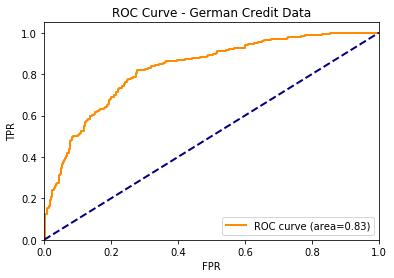

In [118]:
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area=%0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - German Credit Data')
plt.legend(loc='lower right')
plt.show()

In [119]:
roc_auc

0.8261433067950379

#### ROC_AUC 와 C-statistic 의 관계? 알아보자

In [121]:
for i in list(np.arange(0, 1, 0.1)):
    pred_n_class['y_pred'] = 0
    pred_n_class.loc[pred_n_class['probs'] > i, 'y_pred'] = 1
    print("Thresholds", i, "Train accuracy:", round(metrics.accuracy_score(pred_n_class['class'], pred_n_class['y_pred']), 4))

Thresholds 0.0 Train accuracy: 0.2986
Thresholds 0.1 Train accuracy: 0.5457
Thresholds 0.2 Train accuracy: 0.6857
Thresholds 0.30000000000000004 Train accuracy: 0.7571
Thresholds 0.4 Train accuracy: 0.7714
Thresholds 0.5 Train accuracy: 0.7814
Thresholds 0.6000000000000001 Train accuracy: 0.7729
Thresholds 0.7000000000000001 Train accuracy: 0.7557
Thresholds 0.8 Train accuracy: 0.7343
Thresholds 0.9 Train accuracy: 0.7057


#### Train set acc 검증

In [127]:
pred_n_class['y_pred'] = 0
pred_n_class.loc[pred_n_class['probs'] > 0.5, 'y_pred'] = 1
print('\nTrain Confusion Matrix\n\n', 
      pd.crosstab(
          pred_n_class['y_pred'],
          pred_n_class['class'],
          rownames=['Predict'],
          colnames=['Actual'])
     )
print('\nTrain Accuracy: ', round(metrics.accuracy_score(pred_n_class['class'], pred_n_class['y_pred']), 4))


Train Confusion Matrix

 Actual     0    1
Predict          
0        439  101
1         52  108

Train Accuracy:  0.7814


#### Test set acc 검증

In [136]:
pred_n_class_test = pd.DataFrame({'class': test_y, 'probs': logistic_model.predict(sm.add_constant(test_x))})

In [137]:
pred_n_class_test['y_pred'] = 0
pred_n_class_test.loc[pred_n_class_test['probs'] > 0.5, 'y_pred'] = 1

In [138]:
print('\nTest Confusion Matrix\n\n', 
      pd.crosstab(
          pred_n_class_test['y_pred'],
          pred_n_class_test['class'],
          rownames=['Predict'],
          colnames=['Actual'])
     )
print('\nTest Accuracy: ', round(metrics.accuracy_score(pred_n_class_test['class'], pred_n_class_test['y_pred']), 4))


Test Confusion Matrix

 Actual     0   1
Predict         
0        188  46
1         21  45

Test Accuracy:  0.7767
